In [ ]:
# from pandas import read_csv
# from matplotlib import pyplot

# # load dataset
# dataset = read_csv('pollution1.csv', header=0, index_col=0)
# data = dataset.values

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import SimpleRNN
from keras.layers.core import Dense, Dropout
# from helper import series_to_supervised, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from pandas import read_csv
from tensorflow.keras.optimizers import Adam

In [ ]:
# load dataset
dataset = read_csv('pollution1.csv', header=0, index_col=0)
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [ ]:
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])

# ensure all data is float
values = values.astype('float32')

In [ ]:

from pandas import DataFrame
from pandas import concat
import numpy as np

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def mean_absolute_percentage_error(actual, pred):
    for i in range(len(actual)):
        if actual[i] == 0:
            actual[i] = actual[i] - 0.1
    return np.mean(abs((actual - pred) / actual)) * 100

In [ ]:
# specify the number of lag hours
n_hours = 4*24
n_features = 8

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, 1)
print("reframed.shape:", reframed.shape)

reframed.shape: (43704, 776)


In [ ]:
reframed

,var1(t-96),var2(t-96),var3(t-96),var4(t-96),var5(t-96),var6(t-96),var7(t-96),var8(t-96),var1(t-95),var2(t-95),var3(t-95),var4(t-95),var5(t-95),var6(t-95),var7(t-95),var8(t-95),var1(t-94),var2(t-94),var3(t-94),var4(t-94),var5(t-94),var6(t-94),var7(t-94),var8(t-94),var1(t-93),var2(t-93),var3(t-93),var4(t-93),var5(t-93),var6(t-93),var7(t-93),var8(t-93),var1(t-92),var2(t-92),var3(t-92),var4(t-92),var5(t-92),var6(t-92),var7(t-92),var8(t-92),...,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
96,129.0,-16.0,-4.0,1020.0,2.0,1.79,0.0,0.0,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,...,84.0,-22.0,-12.0,1033.0,1.0,13.420000,0.0,0.0,106.0,-24.0,-18.0,1033.0,1.0,16.549999,0.0,0.0,66.0,-22.0,-13.0,1034.0,1.0,20.570000,0.0,0.0,50.0,-22.0,-16.0,1033.0,1.0,23.700001,0.0,0.0,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0
97,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0,...,106.0,-24.0,-18.0,1033.0,1.0,16.549999,0.0,0.0,66.0,-22.0,-13.0,1034.0,1.0,20.570000,0.0,0.0,50.0,-22.0,-16.0,1033.0,1.0,23.700001,0.0,0.0,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0,77.0,-25.0,-14.0,1033.0,0.0,4.020000,0.0,0.0
98,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0,105.0,-7.0,-6.0,1023.0,2.0,8.93,4.0,0.0,...,66.0,-22.0,-13.0,1034.0,1.0,20.570000,0.0,0.0,50.0,-22.0,-16.0,1033.0,1.0,23.700001,0.0,0.0,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0,77.0,-25.0,-14.0,1033.0,0.0,4.020000,0.0,0.0,50.0,-26.0,-14.0,1034.0,0.0,8.040000,0.0,0.0
99,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0,105.0,-7.0,-6.0,1023.0,2.0,8.93,4.0,0.0,124.0,-7.0,-5.0,1024.0,2.0,10.72,0.0,0.0,...,50.0,-22.0,-16.0,1033.0,1.0,23.700001,0.0,0.0,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0,77.0,-25.0,-14.0,1033.0,0.0,4.020000,0.0,0.0,50.0,-26.0,-14.0,1034.0,0.0,8.040000,0.0,0.0,44.0,-26.0,-14.0,1033.0,0.0,13.850000,0.0,0.0
100,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0,105.0,-7.0,-6.0,1023.0,2.0,8.93,4.0,0.0,124.0,-7.0,-5.0,1024.0,2.0,10.72,0.0,0.0,120.0,-8.0,-6.0,1024.0,2.0,12.51,0.0,0.0,...,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0,77.0,-25.0,-14.0,1033.0,0.0,4.020000,0.0,0.0,50.0,-26.0,-14.0,1034.0,0.0,8.040000,0.0,0.0,44.0,-26.0,-14.0,1033.0,0.0,13.850000,0.0,0.0,27.0,-26.0,-14.0,1033.0,0.0,17.870001,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,328.0,-9.0,0.0,1026.0,3.0,2.68,0.0,0.0,349.0,-9.0,-3.0,1026.0,3.0,3.57,0.0,0.0,327.0,-9.0,-4.0,1026.0,3.0,4.46,0.0,0.0,348.0,-7.0,-4.0,1025.0,3.0,5.35,0.0,0.0,363.0,-9.0,-5.0,1025.0,3.0,6.24,0.0,0.0,...,11.0,-26.0,1.0,1032.0,1.0,205.149994,0.0,0.0,8.0,-23.0,0.0,1032.0,1.0,214.089996,0.0,0.0,9.0,-22.0,-1.0,1033.0,1.0,221.240005,0.0,0.0,10.0,-22.0,-2.0,1033.0,1.0,226.160004,0.0,0.0,8.0,-23.0,-2.0,1034.0,1.0,231.970001,0.0,0.0
43796,349.0,-9.0,-3.0,1026.0,3.0,3.57,0.0,0.0,327.0,-9.0,-4.0,1026.0,3.0,4.46,0.0,0.0,348.0,-7.0,-4.0,1025.0,3.0,5.35,0.0,0.0,363.0,-9.0,-5.0,1025.0,3.0,6.24,0.0,0.0,385.0,-9.0,-6.0,1025.0,3.0,6.69,0.0,0.0,...,8.0,-23.0

In [ ]:
reframed.to_csv('supervised')

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = int(len(values)*0.7)
print("n_train_hours:", n_train_hours)

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

n_train_hours: 30592


In [ ]:
import pandas as pd
train_df = pd.DataFrame(train)
train_df

# 98 ~ 30689 in excel index

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775
0,129.0,-16.0,-4.0,1020.0,2.0,1.79,0.0,0.0,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,...,84.0,-22.0,-12.0,1033.0,1.0,13.420000,0.0,0.0,106.0,-24.0,-18.0,1033.0,1.0,16.549999,0.0,0.0,66.0,-22.0,-13.0,1034.0,1.0,20.570000,0.0,0.0,50.0,-22.0,-16.0,1033.0,1.0,23.700001,0.0,0.0,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0
1,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0,...,106.0,-24.0,-18.0,1033.0,1.0,16.549999,0.0,0.0,66.0,-22.0,-13.0,1034.0,1.0,20.570000,0.0,0.0,50.0,-22.0,-16.0,1033.0,1.0,23.700001,0.0,0.0,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0,77.0,-25.0,-14.0,1033.0,0.0,4.020000,0.0,0.0
2,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0,105.0,-7.0,-6.0,1023.0,2.0,8.93,4.0,0.0,...,66.0,-22.0,-13.0,1034.0,1.0,20.570000,0.0,0.0,50.0,-22.0,-16.0,1033.0,1.0,23.700001,0.0,0.0,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0,77.0,-25.0,-14.0,1033.0,0.0,4.020000,0.0,0.0,50.0,-26.0,-14.0,1034.0,0.0,8.040000,0.0,0.0
3,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0,105.0,-7.0,-6.0,1023.0,2.0,8.93,4.0,0.0,124.0,-7.0,-5.0,1024.0,2.0,10.72,0.0,0.0,...,50.0,-22.0,-16.0,1033.0,1.0,23.700001,0.0,0.0,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0,77.0,-25.0,-14.0,1033.0,0.0,4.020000,0.0,0.0,50.0,-26.0,-14.0,1034.0,0.0,8.040000,0.0,0.0,44.0,-26.0,-14.0,1033.0,0.0,13.850000,0.0,0.0
4,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0,105.0,-7.0,-6.0,1023.0,2.0,8.93,4.0,0.0,124.0,-7.0,-5.0,1024.0,2.0,10.72,0.0,0.0,120.0,-8.0,-6.0,1024.0,2.0,12.51,0.0,0.0,...,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0,77.0,-25.0,-14.0,1033.0,0.0,4.020000,0.0,0.0,50.0,-26.0,-14.0,1034.0,0.0,8.040000,0.0,0.0,44.0,-26.0,-14.0,1033.0,0.0,13.850000,0.0,0.0,27.0,-26.0,-14.0,1033.0,0.0,17.870001,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30587,103.0,20.0,23.0,1005.0,0.0,3.58,0.0,0.0,105.0,21.0,24.0,1004.0,2.0,3.13,0.0,0.0,113.0,21.0,24.0,1004.0,2.0,6.26,0.0,0.0,126.0,21.0,24.0,1004.0,3.0,0.89,0.0,0.0,122.0,22.0,25.0,1004.0,0.0,1.79,0.0,0.0,...,56.0,21.0,27.0,996.0,1.0,3.580000,0.0,0.0,44.0,21.0,29.0,997.0,0.0,1.790000,0.0,0.0,31.0,19.0,31.0,997.0,1.0,4.020000,0.0,0.0,30.0,18.0,32.0,996.0,0.0,4.020000,0.0,0.0,14.0,19.0,33.0,996.0,0.0,8.040000,0.0,0.0
30588,105.0,21.0,24.0,1004.0,2.0,3.13,0.0,0.0,113.0,21.0,24.0,1004.0,2.0,6.26,0.0,0.0,126.0,21.0,24.0,1004.0,3.0,0.89,0.0,0.0,122.0,22.0,25.0,1004.0,0.0,1.79,0.0,0.0,133.0,22.0,26.0,1004.0,1.0,3.13,0.0,0.0,...,44.0,21.0,29.0,997.0,0.0,1.790000,0.0,0.0,31.0,19.0,31.0,997.0,1.0,4.020000,0.0,0.0,30.0,18.0,32.0,996.0,0.0,4.020000,0.0,0.0,14.0,19.0,33.0,996.0,0.0,8.040000,0.0,0.0,16.0,16.0,35.0,995.0,1.0,5.810000,0.0,0.0
30589,113.0,21.0,24.0,1004.0,2.0,6.26,0.0,0.0,126.0,21.0,24.0,1004.0,3.0,0.89,0.0,0.0,122.0,22.0,25.0,1004.0,0.0,1.79,0.0,0.0,133.0,22.0,26.0,1004.0,1.0,3.13,0.0,0.0,122.0,22.0,27.0,1004.0,1.0,4.92,0.0,0.0,...,31.0,19.0,31.0,997.0,1.0,4.020000,0.0,0.0,30.0,18.0,32.0,996.0,0.0,4.020000,0.0,0.0,14.0,19.0,33.0,996.0,0.0,8.040000,0.0,0.0,16.0,16.0,35.0,995.0,1.0,5.810000,0.0

In [ ]:
import pandas as pd
test_df = pd.DataFrame(test)
test_df

# 30689 ~ 43801 in excel index

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775
0,133.0,22.0,26.0,1004.0,1.0,3.13,0.0,0.0,122.0,22.0,27.0,1004.0,1.0,4.92,0.0,0.0,120.0,23.0,26.0,1004.0,0.0,1.79,0.0,0.0,125.0,22.0,25.0,1004.0,0.0,3.58,0.0,0.0,137.0,22.0,24.0,1005.0,3.0,0.89,0.0,0.0,...,16.0,16.0,35.0,995.0,1.0,5.810000,0.0,0.0,25.0,16.0,36.0,995.0,1.0,8.940000,0.0,0.0,26.0,14.0,36.0,995.0,1.0,13.860000,0.0,0.0,24.0,15.0,36.0,994.0,1.0,17.879999,0.0,0.0,23.0,17.0,35.0,994.0,1.0,21.900000,0.0,0.0
1,122.0,22.0,27.0,1004.0,1.0,4.92,0.0,0.0,120.0,23.0,26.0,1004.0,0.0,1.79,0.0,0.0,125.0,22.0,25.0,1004.0,0.0,3.58,0.0,0.0,137.0,22.0,24.0,1005.0,3.0,0.89,0.0,0.0,146.0,22.0,24.0,1005.0,3.0,1.78,0.0,0.0,...,25.0,16.0,36.0,995.0,1.0,8.940000,0.0,0.0,26.0,14.0,36.0,995.0,1.0,13.860000,0.0,0.0,24.0,15.0,36.0,994.0,1.0,17.879999,0.0,0.0,23.0,17.0,35.0,994.0,1.0,21.900000,0.0,0.0,14.0,14.0,35.0,994.0,1.0,25.920000,0.0,0.0
2,120.0,23.0,26.0,1004.0,0.0,1.79,0.0,0.0,125.0,22.0,25.0,1004.0,0.0,3.58,0.0,0.0,137.0,22.0,24.0,1005.0,3.0,0.89,0.0,0.0,146.0,22.0,24.0,1005.0,3.0,1.78,0.0,0.0,164.0,22.0,23.0,1005.0,1.0,1.79,0.0,0.0,...,26.0,14.0,36.0,995.0,1.0,13.860000,0.0,0.0,24.0,15.0,36.0,994.0,1.0,17.879999,0.0,0.0,23.0,17.0,35.0,994.0,1.0,21.900000,0.0,0.0,14.0,14.0,35.0,994.0,1.0,25.920000,0.0,0.0,17.0,15.0,35.0,994.0,1.0,29.940001,0.0,0.0
3,125.0,22.0,25.0,1004.0,0.0,3.58,0.0,0.0,137.0,22.0,24.0,1005.0,3.0,0.89,0.0,0.0,146.0,22.0,24.0,1005.0,3.0,1.78,0.0,0.0,164.0,22.0,23.0,1005.0,1.0,1.79,0.0,0.0,164.0,22.0,23.0,1005.0,3.0,0.89,0.0,0.0,...,24.0,15.0,36.0,994.0,1.0,17.879999,0.0,0.0,23.0,17.0,35.0,994.0,1.0,21.900000,0.0,0.0,14.0,14.0,35.0,994.0,1.0,25.920000,0.0,0.0,17.0,15.0,35.0,994.0,1.0,29.940001,0.0,0.0,20.0,17.0,33.0,994.0,1.0,31.730000,0.0,0.0
4,137.0,22.0,24.0,1005.0,3.0,0.89,0.0,0.0,146.0,22.0,24.0,1005.0,3.0,1.78,0.0,0.0,164.0,22.0,23.0,1005.0,1.0,1.79,0.0,0.0,164.0,22.0,23.0,1005.0,3.0,0.89,0.0,0.0,186.0,22.0,23.0,1005.0,1.0,1.79,0.0,0.0,...,23.0,17.0,35.0,994.0,1.0,21.900000,0.0,0.0,14.0,14.0,35.0,994.0,1.0,25.920000,0.0,0.0,17.0,15.0,35.0,994.0,1.0,29.940001,0.0,0.0,20.0,17.0,33.0,994.0,1.0,31.730000,0.0,0.0,31.0,20.0,29.0,994.0,3.0,0.890000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13107,328.0,-9.0,0.0,1026.0,3.0,2.68,0.0,0.0,349.0,-9.0,-3.0,1026.0,3.0,3.57,0.0,0.0,327.0,-9.0,-4.0,1026.0,3.0,4.46,0.0,0.0,348.0,-7.0,-4.0,1025.0,3.0,5.35,0.0,0.0,363.0,-9.0,-5.0,1025.0,3.0,6.24,0.0,0.0,...,11.0,-26.0,1.0,1032.0,1.0,205.149994,0.0,0.0,8.0,-23.0,0.0,1032.0,1.0,214.089996,0.0,0.0,9.0,-22.0,-1.0,1033.0,1.0,221.240005,0.0,0.0,10.0,-22.0,-2.0,1033.0,1.0,226.160004,0.0,0.0,8.0,-23.0,-2.0,1034.0,1.0,231.970001,0.0,0.0
13108,349.0,-9.0,-3.0,1026.0,3.0,3.57,0.0,0.0,327.0,-9.0,-4.0,1026.0,3.0,4.46,0.0,0.0,348.0,-7.0,-4.0,1025.0,3.0,5.35,0.0,0.0,363.0,-9.0,-5.0,1025.0,3.0,6.24,0.0,0.0,385.0,-9.0,-6.0,1025.0,3.0,6.69,0.0,0.0,...,8.0,-23.0,0.0,1032.0,1.0,214.089996,0.0,0.0,9.0,-22.0,-1.0,1033.0,1.0,221.240005,0.0,0.0,10.0,-22.0,-2.0,1033.0,1.0,226.160004,0.0,0.0,8.0,-23.0,-2.0,1034.0,1.0,231.970001,0.0,0.0,10.0,-22.0,-3.0,1034.0,1.0,237.779999,0.0,0.0
13109,327.0,-9.0,-4.0,1026.0,3.0,4.46,0.0,0.0,348.0,-7.0,-4.0,1025.0,3.0,5.35,0.0,0.0,363.0,-9.0,-5.0,1025.0,3.0,6.24,0.0,0.0,385.0,-9.0,-6.0,1025.0,3.0,6.69,0.0,0.0,393.0,-9.0,-4.0,1024.0,0.0,1.79,0.0,0.0,...,9.0,-22.0,-1.0,1033.0,1.0,221.240005,0.0,0.0,10.0,-22.0,-2.0,1033.0,1.0,226.160004,0.0,0.0,8.0,-23.0,-2.0,1034.0,1.0,231.970001,0.0,0.0,10.0,-22.0,-3.0,1034.0,1.0,237.779999,0.0,0.0,10.0,-22.0,-3.0,1034.0,1.0,242.699

In [ ]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [ ]:
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (30592, 768) (30592,) (13112, 768) (13112,)


In [ ]:
train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (30592, 768) (30592, 1) (13112, 768) (13112, 1)


In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (30592, 96, 8) (30592, 1) (13112, 96, 8) (13112, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 64)                49216     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,281
Trainable params: 49,281
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (No

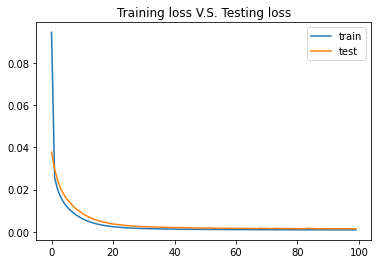

In [ ]:
# Simple RNN Model
lr = 0.00005
EPOCHS = 100
model = keras.Sequential()
# model.add(SimpleRNN(1, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.2))
model.add(layers.Flatten(input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))   # Regression -> No Need for Activation
model.summary()
print(model.summary())
model.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
              # optimizer='adam',
              loss='mse',
              metrics=['mae'])
history = model.fit(train_X, train_y,
                    batch_size=256,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y))


plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Training loss V.S. Testing loss")
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = scaler.inverse_transform(test_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

# calculate RMSE, MAE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)

inv_y.shape, inv_yhat.shape (13112, 1) (13112, 1)
Test RMSE: 24.932
Test MAE: 14.818
Test MAPE: 473.653


In [ ]:
test_df = pd.DataFrame(test)
test_df

# 30689 ~ 43801 in excel index

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775
0,133.0,22.0,26.0,1004.0,1.0,3.13,0.0,0.0,122.0,22.0,27.0,1004.0,1.0,4.92,0.0,0.0,120.0,23.0,26.0,1004.0,0.0,1.79,0.0,0.0,125.0,22.0,25.0,1004.0,0.0,3.58,0.0,0.0,137.0,22.0,24.0,1005.0,3.0,0.89,0.0,0.0,...,16.0,16.0,35.0,995.0,1.0,5.810000,0.0,0.0,25.0,16.0,36.0,995.0,1.0,8.940000,0.0,0.0,26.0,14.0,36.0,995.0,1.0,13.860000,0.0,0.0,24.0,15.0,36.0,994.0,1.0,17.879999,0.0,0.0,23.0,17.0,35.0,994.0,1.0,21.900000,0.0,0.0
1,122.0,22.0,27.0,1004.0,1.0,4.92,0.0,0.0,120.0,23.0,26.0,1004.0,0.0,1.79,0.0,0.0,125.0,22.0,25.0,1004.0,0.0,3.58,0.0,0.0,137.0,22.0,24.0,1005.0,3.0,0.89,0.0,0.0,146.0,22.0,24.0,1005.0,3.0,1.78,0.0,0.0,...,25.0,16.0,36.0,995.0,1.0,8.940000,0.0,0.0,26.0,14.0,36.0,995.0,1.0,13.860000,0.0,0.0,24.0,15.0,36.0,994.0,1.0,17.879999,0.0,0.0,23.0,17.0,35.0,994.0,1.0,21.900000,0.0,0.0,14.0,14.0,35.0,994.0,1.0,25.920000,0.0,0.0
2,120.0,23.0,26.0,1004.0,0.0,1.79,0.0,0.0,125.0,22.0,25.0,1004.0,0.0,3.58,0.0,0.0,137.0,22.0,24.0,1005.0,3.0,0.89,0.0,0.0,146.0,22.0,24.0,1005.0,3.0,1.78,0.0,0.0,164.0,22.0,23.0,1005.0,1.0,1.79,0.0,0.0,...,26.0,14.0,36.0,995.0,1.0,13.860000,0.0,0.0,24.0,15.0,36.0,994.0,1.0,17.879999,0.0,0.0,23.0,17.0,35.0,994.0,1.0,21.900000,0.0,0.0,14.0,14.0,35.0,994.0,1.0,25.920000,0.0,0.0,17.0,15.0,35.0,994.0,1.0,29.940001,0.0,0.0
3,125.0,22.0,25.0,1004.0,0.0,3.58,0.0,0.0,137.0,22.0,24.0,1005.0,3.0,0.89,0.0,0.0,146.0,22.0,24.0,1005.0,3.0,1.78,0.0,0.0,164.0,22.0,23.0,1005.0,1.0,1.79,0.0,0.0,164.0,22.0,23.0,1005.0,3.0,0.89,0.0,0.0,...,24.0,15.0,36.0,994.0,1.0,17.879999,0.0,0.0,23.0,17.0,35.0,994.0,1.0,21.900000,0.0,0.0,14.0,14.0,35.0,994.0,1.0,25.920000,0.0,0.0,17.0,15.0,35.0,994.0,1.0,29.940001,0.0,0.0,20.0,17.0,33.0,994.0,1.0,31.730000,0.0,0.0
4,137.0,22.0,24.0,1005.0,3.0,0.89,0.0,0.0,146.0,22.0,24.0,1005.0,3.0,1.78,0.0,0.0,164.0,22.0,23.0,1005.0,1.0,1.79,0.0,0.0,164.0,22.0,23.0,1005.0,3.0,0.89,0.0,0.0,186.0,22.0,23.0,1005.0,1.0,1.79,0.0,0.0,...,23.0,17.0,35.0,994.0,1.0,21.900000,0.0,0.0,14.0,14.0,35.0,994.0,1.0,25.920000,0.0,0.0,17.0,15.0,35.0,994.0,1.0,29.940001,0.0,0.0,20.0,17.0,33.0,994.0,1.0,31.730000,0.0,0.0,31.0,20.0,29.0,994.0,3.0,0.890000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13107,328.0,-9.0,0.0,1026.0,3.0,2.68,0.0,0.0,349.0,-9.0,-3.0,1026.0,3.0,3.57,0.0,0.0,327.0,-9.0,-4.0,1026.0,3.0,4.46,0.0,0.0,348.0,-7.0,-4.0,1025.0,3.0,5.35,0.0,0.0,363.0,-9.0,-5.0,1025.0,3.0,6.24,0.0,0.0,...,11.0,-26.0,1.0,1032.0,1.0,205.149994,0.0,0.0,8.0,-23.0,0.0,1032.0,1.0,214.089996,0.0,0.0,9.0,-22.0,-1.0,1033.0,1.0,221.240005,0.0,0.0,10.0,-22.0,-2.0,1033.0,1.0,226.160004,0.0,0.0,8.0,-23.0,-2.0,1034.0,1.0,231.970001,0.0,0.0
13108,349.0,-9.0,-3.0,1026.0,3.0,3.57,0.0,0.0,327.0,-9.0,-4.0,1026.0,3.0,4.46,0.0,0.0,348.0,-7.0,-4.0,1025.0,3.0,5.35,0.0,0.0,363.0,-9.0,-5.0,1025.0,3.0,6.24,0.0,0.0,385.0,-9.0,-6.0,1025.0,3.0,6.69,0.0,0.0,...,8.0,-23.0,0.0,1032.0,1.0,214.089996,0.0,0.0,9.0,-22.0,-1.0,1033.0,1.0,221.240005,0.0,0.0,10.0,-22.0,-2.0,1033.0,1.0,226.160004,0.0,0.0,8.0,-23.0,-2.0,1034.0,1.0,231.970001,0.0,0.0,10.0,-22.0,-3.0,1034.0,1.0,237.779999,0.0,0.0
13109,327.0,-9.0,-4.0,1026.0,3.0,4.46,0.0,0.0,348.0,-7.0,-4.0,1025.0,3.0,5.35,0.0,0.0,363.0,-9.0,-5.0,1025.0,3.0,6.24,0.0,0.0,385.0,-9.0,-6.0,1025.0,3.0,6.69,0.0,0.0,393.0,-9.0,-4.0,1024.0,0.0,1.79,0.0,0.0,...,9.0,-22.0,-1.0,1033.0,1.0,221.240005,0.0,0.0,10.0,-22.0,-2.0,1033.0,1.0,226.160004,0.0,0.0,8.0,-23.0,-2.0,1034.0,1.0,231.970001,0.0,0.0,10.0,-22.0,-3.0,1034.0,1.0,237.779999,0.0,0.0,10.0,-22.0,-3.0,1034.0,1.0,242.699

In [ ]:
reframed

,var1(t-96),var2(t-96),var3(t-96),var4(t-96),var5(t-96),var6(t-96),var7(t-96),var8(t-96),var1(t-95),var2(t-95),var3(t-95),var4(t-95),var5(t-95),var6(t-95),var7(t-95),var8(t-95),var1(t-94),var2(t-94),var3(t-94),var4(t-94),var5(t-94),var6(t-94),var7(t-94),var8(t-94),var1(t-93),var2(t-93),var3(t-93),var4(t-93),var5(t-93),var6(t-93),var7(t-93),var8(t-93),var1(t-92),var2(t-92),var3(t-92),var4(t-92),var5(t-92),var6(t-92),var7(t-92),var8(t-92),...,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
96,129.0,-16.0,-4.0,1020.0,2.0,1.79,0.0,0.0,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,...,84.0,-22.0,-12.0,1033.0,1.0,13.420000,0.0,0.0,106.0,-24.0,-18.0,1033.0,1.0,16.549999,0.0,0.0,66.0,-22.0,-13.0,1034.0,1.0,20.570000,0.0,0.0,50.0,-22.0,-16.0,1033.0,1.0,23.700001,0.0,0.0,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0
97,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0,...,106.0,-24.0,-18.0,1033.0,1.0,16.549999,0.0,0.0,66.0,-22.0,-13.0,1034.0,1.0,20.570000,0.0,0.0,50.0,-22.0,-16.0,1033.0,1.0,23.700001,0.0,0.0,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0,77.0,-25.0,-14.0,1033.0,0.0,4.020000,0.0,0.0
98,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0,105.0,-7.0,-6.0,1023.0,2.0,8.93,4.0,0.0,...,66.0,-22.0,-13.0,1034.0,1.0,20.570000,0.0,0.0,50.0,-22.0,-16.0,1033.0,1.0,23.700001,0.0,0.0,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0,77.0,-25.0,-14.0,1033.0,0.0,4.020000,0.0,0.0,50.0,-26.0,-14.0,1034.0,0.0,8.040000,0.0,0.0
99,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0,105.0,-7.0,-6.0,1023.0,2.0,8.93,4.0,0.0,124.0,-7.0,-5.0,1024.0,2.0,10.72,0.0,0.0,...,50.0,-22.0,-16.0,1033.0,1.0,23.700001,0.0,0.0,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0,77.0,-25.0,-14.0,1033.0,0.0,4.020000,0.0,0.0,50.0,-26.0,-14.0,1034.0,0.0,8.040000,0.0,0.0,44.0,-26.0,-14.0,1033.0,0.0,13.850000,0.0,0.0
100,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0,105.0,-7.0,-6.0,1023.0,2.0,8.93,4.0,0.0,124.0,-7.0,-5.0,1024.0,2.0,10.72,0.0,0.0,120.0,-8.0,-6.0,1024.0,2.0,12.51,0.0,0.0,...,56.0,-25.0,-17.0,1033.0,1.0,26.830000,0.0,0.0,77.0,-25.0,-14.0,1033.0,0.0,4.020000,0.0,0.0,50.0,-26.0,-14.0,1034.0,0.0,8.040000,0.0,0.0,44.0,-26.0,-14.0,1033.0,0.0,13.850000,0.0,0.0,27.0,-26.0,-14.0,1033.0,0.0,17.870001,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,328.0,-9.0,0.0,1026.0,3.0,2.68,0.0,0.0,349.0,-9.0,-3.0,1026.0,3.0,3.57,0.0,0.0,327.0,-9.0,-4.0,1026.0,3.0,4.46,0.0,0.0,348.0,-7.0,-4.0,1025.0,3.0,5.35,0.0,0.0,363.0,-9.0,-5.0,1025.0,3.0,6.24,0.0,0.0,...,11.0,-26.0,1.0,1032.0,1.0,205.149994,0.0,0.0,8.0,-23.0,0.0,1032.0,1.0,214.089996,0.0,0.0,9.0,-22.0,-1.0,1033.0,1.0,221.240005,0.0,0.0,10.0,-22.0,-2.0,1033.0,1.0,226.160004,0.0,0.0,8.0,-23.0,-2.0,1034.0,1.0,231.970001,0.0,0.0
43796,349.0,-9.0,-3.0,1026.0,3.0,3.57,0.0,0.0,327.0,-9.0,-4.0,1026.0,3.0,4.46,0.0,0.0,348.0,-7.0,-4.0,1025.0,3.0,5.35,0.0,0.0,363.0,-9.0,-5.0,1025.0,3.0,6.24,0.0,0.0,385.0,-9.0,-6.0,1025.0,3.0,6.69,0.0,0.0,...,8.0,-23.0

In [ ]:
# baseline = reframed.iloc[30704:31065, -8] (0 <--> 96, 30609 <--> 30705)
# baseline = reframed.iloc[30608:30967, -8]
baseline = reframed.iloc[30607:30966, -8]
baseline.reset_index(inplace=True, drop=True)
baseline

0       19.0
1       24.0
2       21.0
3       18.0
4       19.0
       ...  
354    107.0
355    126.0
356    141.0
357    146.0
358    160.0
Name: var1(t), Length: 359, dtype: float32

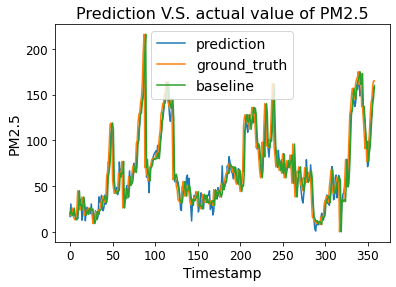

In [ ]:
# plot Prediction V.S. actual value of PM2.5
#          
# [] <-> 30688 in codes --> first test data --> 30690 in excel
# [] <-> 30688 in codes --> 0 --> 30690 in excel
# [] <-> 30705 in codes --> 17 --> 30707 in excel --> 2013-07-04-09:00
# [] <-> 31064 in codes --> 376 --> 31066 in excel --> 2013-07-19-8:00



# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.plot(inv_yhat[17:376], label='prediction')
plt.plot(inv_y[17:376], label='ground_truth')
plt.plot(baseline, label='baseline')
plt.title("Prediction V.S. actual value of PM2.5", fontsize='16')
plt.xlabel('Timestamp', fontsize='14')
plt.ylabel('PM2.5', fontsize='14')
plt.legend(prop={"size":14})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig('graph/rnn_prediction.png', dpi=300)
plt.show()


In [ ]:
# make a prediction
yhat = model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = scaler.inverse_transform(test_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

baseline = pd.DataFrame(baseline)
print(baseline.shape)

# calculate RMSE, MAE
rmse_rnn = sqrt(mean_squared_error(inv_y[17:376], inv_yhat[17:376]))
mae_rnn = mean_absolute_error(inv_y[17:376], inv_yhat[17:376])

rmse_base = sqrt(mean_squared_error(inv_y[17:376], baseline))
mae_base = mean_absolute_error(inv_y[17:376], baseline)

print('Test RMSE of RNN: %.3f' % rmse_rnn)
print('Test MAE of RNN: %.3f' % mae_rnn)
print('Test RMSE of Baseline: %.3f' % rmse_base)
print('Test MAE of Baseline: %.3f' % mae_base)

# print('Test MAPE: %.3f' % mape)

inv_y.shape, inv_yhat.shape (13112, 1) (13112, 1)
(359, 1)
Test RMSE of RNN: 16.107
Test MAE of RNN: 11.256
Test RMSE of Baseline: 21.281
Test MAE of Baseline: 13.624


In [ ]:
# make a prediction
yhat = model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = scaler.inverse_transform(test_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

baseline = pd.DataFrame(baseline)
print(baseline.shape)

# calculate RMSE, MAE
rmse_rnn = sqrt(mean_squared_error(inv_y[17:376], inv_yhat[17:376]))
mae_rnn = mean_absolute_error(inv_y[17:376], inv_yhat[17:376])

rmse_base = sqrt(mean_squared_error(inv_y[17:376], baseline))
mae_base = mean_absolute_error(inv_y[17:376], baseline)

print('Test RMSE of RNN: %.3f' % rmse_rnn)
print('Test MAE of RNN: %.3f' % mae_rnn)
print('Test RMSE of Baseline: %.3f' % rmse_base)
print('Test MAE of Baseline: %.3f' % mae_base)

# print('Test MAPE: %.3f' % mape)

inv_y.shape, inv_yhat.shape (13112, 1) (13112, 1)
(359, 1)
Test RMSE of RNN: 16.828
Test MAE of RNN: 11.813
Test RMSE of Baseline: 21.281
Test MAE of Baseline: 13.624


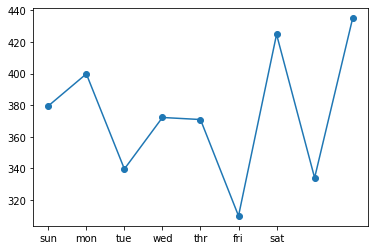

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
scores = [ 379.5, 399.8, 339.6, 372.2, 370.9, 309.9, 424.8, 334, 435]
plt.plot(scores, marker='o', label='lstm')
plt.xticks(np.arange(7), days)
plt.show()